(credal)=
# Credal Sets and Classifiers

In [280]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import matplotlib as mpl
# Vector Graphics
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


from itertools import chain, combinations

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.datasets import make_blobs, load_wine

import mpltern

from scipy.stats import dirichlet

In [281]:
# seed everything
np.random.seed(1)
sk_rstate = 42
sp_state = 42

<div align="justify">

The theory of imprecise probabilities ({cite:t}`wall_sr`) is largely built on the idea to specify
knowledge in terms of a set $Q$ of probability distributions instead of a single distribution.
In the literature, such sets are also referred to as *credal sets*, and often assumed to be
convex (i.e.,$q , q' \in Q$ implies $\alpha q + (1-\alpha) q' \in Q$ for all $\alpha \in [0,1]$).
The concept of credal
sets and related notions provide the basis of a generalization of Bayesian inference, which
is especially motivated by the criticism of non-informative priors as models of ignorance
in standard Bayesian inference (cf. {doc}`../chapter-modelingAproxUncertainty/modelingAproxUncertainty`). The basic idea is to replace a single
prior distribution on the model space, as used in Bayesian inference, by a (credal) set of
candidate priors. Given a set of observed data, Bayesian inference can then be applied
to each candidate prior, thereby producing a (credal) set of posteriors. Correspondingly,
any value or quantity derived from a posterior (e.g., a prediction, an expected value,
etc.) is replaced by a set of such values or quantities. An important example of such
an approach is robust inference for categorical data with the imprecise Dirichlet model,
which is an extension of inference with the Dirichlet distribution as a conjugate prior for
the multinomial distribution ({cite:t}`bern_ai05`).

</div>

## Naive Credal Classifier

<div align="justify">

Methods of that kind have also been used in the context of machine learning, for example in the framework of the Naïve Credal Classifier ({cite:t}`zaffalon2002,cora_lr08`) or more recently as an extension of sum-product networks ({cite:t}`dera_cs17`). As for the former, we can think of a Naïve Bayes (NB) classifier as a hypothesis $h = h_{\vec{\theta}}$ specified by a parameter vector ${\vec{\theta}}$ that comprises a prior probability $\theta_k$ for each class $y_k \in \set{Y}$ and a conditional probability $\theta_{i,j,k}$ for observing the $i^{th}$ value $a_{i,j}$ of the $j^{th}$ attribute given class $y_k$. For a given query instance specified by attributes $(a_{i_1,1}, \ldots , a_{i_J,J})$, the posterior class probabilities are then given by

$$
p(y_k | a_{i_1,1}, \ldots , a_{i_J,J}) \propto \theta_k \prod_{j=1}^J \theta_{i_j,j,k} \,.
\enspace
$$(spo)

</div>

For illustration we use the wine dataset.  We discretize it to make it suitable for categorical naive bayes and also drop some attributes to introduce more uncertainty:

In [282]:
# Load and discretize the Wine dataset

columns = [0, 1, 2, 3]
wine = load_wine()
X = wine.data[:,columns]
y = wine.target

target_names = wine.target_names
feature_names = np.array(wine.feature_names)[columns]

# discretize data 
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform',subsample=None)
X_binned = discretizer.fit_transform(X)

# create df for visualization
bin_labels = ['low', 'medium', 'high']
X_binned_labeled = pd.DataFrame(X_binned, columns=feature_names).map(lambda x: bin_labels[int(x)])
y_df = pd.DataFrame(y, columns=['target'])
y_df['target_name'] = y_df['target'].map(lambda x: target_names[x])
wine_df = pd.concat([X_binned_labeled, y_df], axis=1)

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_binned, y, test_size=0.2, random_state=sk_rstate)

wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,target,target_name
0,high,low,medium,low,0,class_0
1,medium,low,medium,low,0,class_0
2,medium,low,high,medium,0,class_0
3,high,low,medium,low,0,class_0
4,medium,medium,high,medium,0,class_0


<div align="justify">

When we train a regular categorical Naive Bayes classifier the prior probabilities $\theta_k$ for each class are calculated as the relative frequencies of class $k$ in the whole dataset. The conditionals $\theta_{i,j,k}$ as the share of observations for which attribute $j$ has the value $i$ given that the class is $k$.

</div>

In [283]:
# init categori1cal NB without laplace smoothing
model = CategoricalNB(alpha=1.)

# train NB
model.fit(X_train, y_train)

# get prior probabilites from model
model.class_prior
prior_probabilities = np.exp(model.class_log_prior_).round(3)
print('Prior probabilities:\n%s'%{c : p for c, p in zip(target_names, prior_probabilities)})

Prior probabilities:
{'class_0': 0.317, 'class_1': 0.401, 'class_2': 0.282}


In [284]:
# get conditional probabilities from model
conditionals = model.feature_log_prob_

conditionals_alcohol = np.exp(conditionals[0]).round(3)

values = ['low', 'medium', 'high']
print('Conditional probabilities of feature 1 values given targets:')
{c: {v : conditionals_alcohol[i][j] for j, v in enumerate(['low', 'medium', 'high'])}
 for i, c in enumerate(target_names)}

Conditional probabilities of feature 1 values given targets:


{'class_0': {'low': 0.021, 'medium': 0.396, 'high': 0.583},
 'class_1': {'low': 0.55, 'medium': 0.4, 'high': 0.05},
 'class_2': {'low': 0.093, 'medium': 0.651, 'high': 0.256}}

<div align="justify">

After that point predictions are made by computing the likelihood of a query as the product of the corresponding priors and conditionals:

</div>

In [285]:
point_predictions = model.predict_proba(X_test).round(3)
print(f'Point predictions for first ten queries: \n {point_predictions[:10]}')

Point predictions for first ten queries: 
 [[0.898 0.032 0.07 ]
 [0.205 0.048 0.747]
 [0.08  0.111 0.809]
 [0.828 0.064 0.109]
 [0.042 0.929 0.029]
 [0.828 0.064 0.109]
 [0.009 0.655 0.336]
 [0.057 0.159 0.784]
 [0.038 0.91  0.051]
 [0.057 0.159 0.784]]


<div align="justify">


In the Naïve Credal Classifier, the $\theta_k$ and $\theta_{i_j,j,k}$ are specified in terms of (local) credal sets, i.e., there is a class of probability distributions $Q$ on $\set{Y}$ playing the role of candidate priors, and a class of probability distributions $Q_{j,k}$ specifying possible distributions on the attribute values of the $j^{th}$ attribute given class $y_k$. A single posterior class probability {eq}`spo` is then replaced by the set (interval) of such probabilities that can be produced by taking $\theta_k$ from a distribution in $Q$ and $\theta_{i_j,j,k}$ from a distribution in $Q_{j,k}$. As an aside, let us note that the computations involved may of course become costly.

</div>

### Imprecise Dirichlet Model

<div align="justify">


To obtain the credal sets over priors and conditionals the imprecise dirchlet model can be used.({cite:t}`zaff_tn02`) The key idea is to model uncertainty about the observations by drawing random samples around them from a dirichlet distribution. For this the concentration parameters $\alpha=(\alpha_{1},...,\alpha_{k})$ of the dirichlet distribution are parametrized as $st$. The empirical priors and conditionals as used in the normal Naive Bayes are used as the parameter $t$:

</div>

In [286]:
s = 5
t = prior_probabilities
prior_credal = dirichlet(s*t).rvs(size=3, random_state=sp_state)
print(f'Empirical prior:{prior_probabilities}\nPrior credal_set:' )
prior_credal.round(4)

Empirical prior:[0.317 0.401 0.282]
Prior credal_set:


array([[0.4462, 0.3532, 0.2006],
       [0.13  , 0.6009, 0.2691],
       [0.1724, 0.5359, 0.2917]])

<div align="justify">


The parameter $s > 0$ is a fixed constant that can be used to express the degree of believe into the observations. Choosing $s$ to be high will cause the distribution to be more concentrated around $t$. Thus the distribution is less spread out and the uncertainty reduced.

</div>

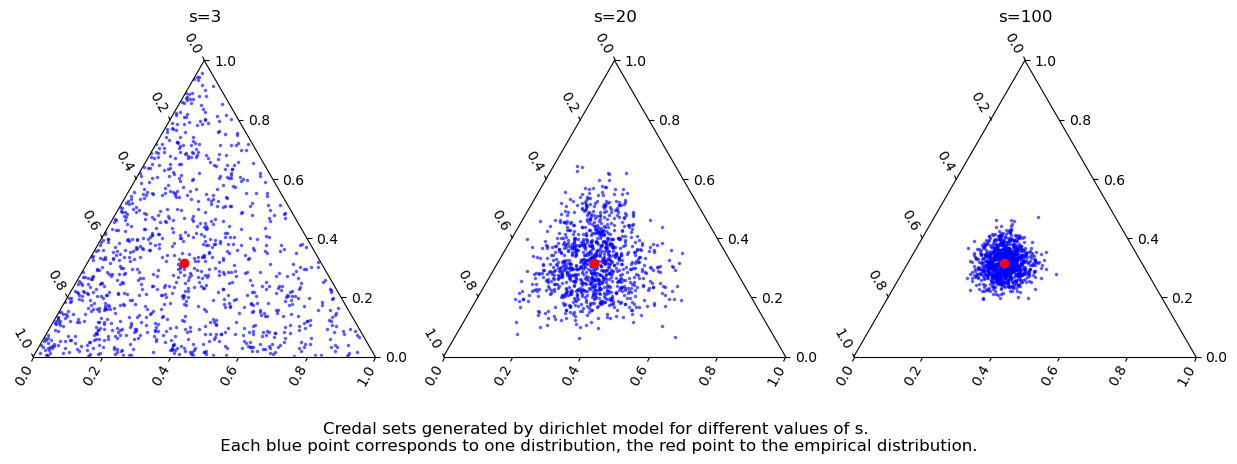

In [287]:
def create_ternary_plots(t):
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5), subplot_kw={'projection': 'ternary'})
    s_vals= [3, 20, 100]
    
    for i, ax in enumerate(axes):
        s = s_vals[i]
        samples = dirichlet(s*t).rvs(size=1000, random_state=sp_state)
        
        ax.scatter(samples[:,0], samples[:,1], samples[:,2], marker='.', s=10, alpha=0.5, color='blue')
        ax.scatter(t[0], t[1], t[2], color='red')
        ax.set_title(f's={s}')
    fig.text(0.5, 0.01, 'Credal sets generated by dirichlet model for different values of s.\n Each blue point corresponds to one distribution, the red point to the empirical distribution.', 
                           ha='center', fontsize=12)
    plt.show()

create_ternary_plots(t)

<div align="justify">


The Naive Credal Classifier produces set predictions as credal sets of posterior distributions. This is done by computing a posterior distribution for each combination of prior and conditional distributions out of the prior and conditional credal sets. While this is impractical we can approximate the true solution by computing the posterior for a fixed number of samples from the prior and posterior credal sets:

</div>

In [288]:
class CategoricalNCC:
    
    def fit(self, X, y):
        self.model = CategoricalNB()
        self.model.fit(X, y)
        
        self.n_classes = len(np.unique(y))
        self.data_size = len(y)
        self.class_frequencies = np.exp(self.model.class_log_prior_)
        self.conditional_frequencies = [np.exp(p) for p in 
                                        self.model.feature_log_prob_]
        
    def predict(self, X, sample_size, s=5):
        
        #s = self.data_size / 10
        
        posterior_credal_sets = []
        
        for i in range(sample_size):
            
            # sample priors
            dirichlet_priors = np.log(dirichlet(s*self.class_frequencies).rvs(size=1, random_state=sp_state))
            
            # sample conditionals
            dirichlet_conditionals = [np.array([np.log(dirichlet(s*freq).rvs(size=1)[0]) for freq in feature]) 
                                               for feature in self.conditional_frequencies]
            
            model = self.model
            model.class_log_prior_ = dirichlet_priors
            model.feature_log_prob_ = dirichlet_conditionals
            #with warnings.catch_warnings():
            #    warnings.simplefilter("ignore")
            #    pred = model.predict_proba(X)
            pred = model.predict_proba(X)
            posterior_credal_sets.append(pred)
            
        posterior_credal_sets = np.transpose(np.array(posterior_credal_sets), (1,0,2)).round(3)
        
        return np.array(posterior_credal_sets).round(3)

<div align="justify">


With this we can train the Naive Credal Classifier on the test data and obtain a posterior credal set for each query in the training data. So for each of the 36 entries in the test dataset we obtain a credal set of 1000 distributions. Each distribution in the credal represents probabilities for each class equivalently to the point predictions obtained earlier. Comparing some of the distributions in a queries credal set with the point prediction made for the same query shows that the probabilities are similar however the credal set contains some variation around the point prediction. This can be interpreted as the uncertainty contained in that model, which could then be analyzed with the methods discussed in [](uncertainty_measures). It is also possible to produce uncertainty aware predictions using {ref}`set_predictions`.


</div>

In [289]:
# Train NCC model
model = CategoricalNCC()
model.fit(X_train,y_train)

# get prediction
wine_credal_sets = model.predict(X_test, 1000, s=50)

print(f'Shape: \n{wine_credal_sets.shape}')
print(f'First distributions of credal set for first query: \n {wine_credal_sets[0][:10]}')
print(f'Naive Bayes prediction for first query: \n{point_predictions[0]}')


Shape: 
(36, 1000, 3)
First distributions of credal set for first query: 
 [[0.881 0.014 0.106]
 [0.922 0.051 0.026]
 [0.967 0.014 0.018]
 [0.628 0.057 0.315]
 [0.943 0.046 0.011]
 [0.944 0.011 0.045]
 [0.801 0.083 0.116]
 [0.863 0.074 0.063]
 [0.916 0.024 0.06 ]
 [0.818 0.136 0.046]]
Naive Bayes prediction for first query: 
[0.898 0.032 0.07 ]


<div align="justify">


We can get a better understanding for the predictions of the Naive credal classifier by visualizing some of the posterior credal sets in a barycentric coordinate system. Each of the blue points represents one distribution within the posterior credal set, the red point the point prediction made by the basic Naive Bayes model. We can see how the Naive Credal Classifier models uncertainty about the point prediction by creating a credal set around it:

</div>

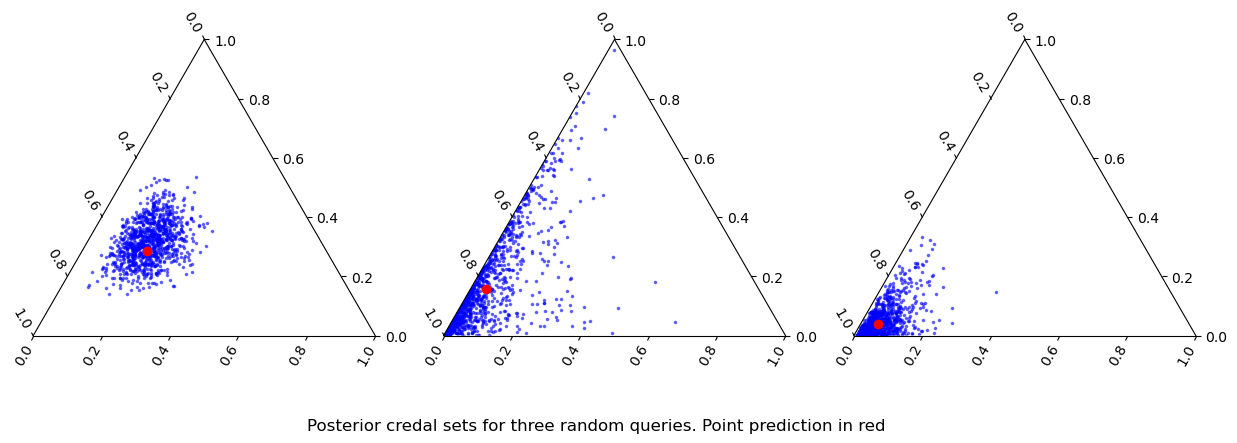

In [290]:
def create_posterior_plot(credal_sets, point_predictions, ridx, title, axtitles=['','','']):
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5), subplot_kw={'projection': 'ternary'})
    
    for i, ax in enumerate(axes):

        credal_set = credal_sets[ridx[i]]
        point = point_predictions[ridx[i]]
        
        ax.scatter(credal_set[:,0], credal_set[:,1], credal_set[:,2], marker='.', s=10, alpha=0.5, color='blue')
        #ax.scatter(*credal_set[:,:], marker='.', s=10, alpha=0.5, color='blue')
        ax.scatter(*point, color='red')
        ax.set_title(axtitles[i])
    fig.text(0.5, 0.01, title, 
                           ha='center', fontsize=12)
    plt.show()

# visualize credal sets of 3 random queries
title = "Posterior credal sets for three random queries. Point prediction in red"
ridx = np.random.choice(np.arange(len(wine_credal_sets)),3)
create_posterior_plot(wine_credal_sets, point_predictions, ridx, title)

(uncertainty_measures)=
## Uncertainty measures for credal sets

<div align="justify">


Interestingly, there has been quite some work on defining uncertainty measures for credal sets and related representation, such as Dempster-Shafer evidence theory ({cite:t}`klir_mo94`). Even more interestingly, a basic distinction between two types of uncertainty contained in a credal set, referred to as *conflict* (randomness, discord) and *non-specificity*, respectively, has been made by ({cite:t}`yage_ea83`). The importance of this distinction was already emphasized by ({cite:t}`kolm_ta65`). These notions are in direct correspondence with what we call aleatoric and epistemic uncertainty. 

</div>

<div align="justify">

### Credal set for demonstration of uncertainty measures
For illustration of the uncertainty measures we will introduce a second dataset that consists of two features and three classes. To obtain credal sets for all queries in the test set we train three different Gaussian Naive Bayes Classifiers on random subsets of the training set and combine the probability predictions. The idea is to obtain three conflicting predictions from the classifiers. This allows us to distinguish between different kinds of uncertainty. Aleatoric uncertainty will be high in the areas in which the three clusters overlap while epistemic uncertainty will be high in areas where we have no data or in which the classifiers produce different predictions. The two dimensionality of the data set allows us to easily visualize conflicting predictions as well as uncertainty in different regions.

The new dataset consists of a gaussian cluster for each of the three classes:


</div>

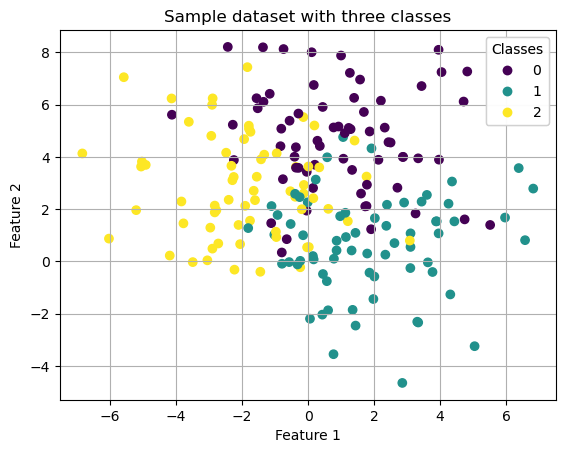

In [291]:
# generate dataset
X, y = make_blobs(n_samples=200, centers=3, n_features=2, random_state=0, cluster_std=2.)

# visualize dataset
scatter = plt.scatter(X[:,0], X[:,1], c=y)
plt.title('Sample dataset with three classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)
plt.show()

<div align="justify">


Next we train the different classifiers on them and combine their predictions to the credal set.

</div>

In [292]:
def get_posterior_credal_set(X, classifiers):
    # constructs posterior credal set out of classifier predictions
    
    # get posterior class probabilities
    probabilities = [classifier.predict_proba(X) 
                     for classifier in classifiers]
    
    # combine posteriors into credal sets
    credal_sets = np.transpose(np.array(probabilities), (1,0,2))
    credal_sets = np.round(credal_sets, 3)
    return credal_sets

In [293]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train three Naive bayes classifiers on subsets of training data

classifiers = []

for _ in range(3):
    indices = np.random.choice(len(X_train), 30, replace=False)
    X_subset, y_subset = X_train[indices], y_train[indices]
    
    model = GaussianNB()
    model.fit(X_subset, y_subset)
    
    classifiers.append(model)

credal_sets = get_posterior_credal_set(X_test, classifiers).round(4)
print(f'Credal set of first test data query:\n {credal_sets[0]}')

Credal set of first test data query:
 [[0.882 0.005 0.113]
 [0.904 0.068 0.028]
 [0.746 0.002 0.252]]


<div align="justify">


We can visualize the different predicitons by plotting the decision boundary for each classifier: 

</div>

In [294]:
def plot_differnces_in_boundary_old(classifiers, X, ax):

	x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
	y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    
	x = np.linspace(x_min,x_max, 100)
	y = np.linspace(y_min, y_max, 100)

	xv, yv = np.meshgrid(x,y)
    
	points = np.column_stack((xv.ravel(), yv.ravel()))

	pr = np.vstack([classifier.predict(points) for classifier in classifiers])
	nvotes = np.array([len(np.unique(pr[:, i])) for i in range(len(points))]).reshape((100,100))
	
	# Define a custom colormap
	colors = ['red', 'blue', 'green']
	cmap = mcolors.ListedColormap(colors)
	bounds = [0, 1, 2, 3]
	norm = mcolors.BoundaryNorm(bounds, cmap.N)

	contour = ax.contourf(x, y, nvotes, cmap=cmap, alpha=0.9)

	# Create a legend
	legend_labels = {
        0: "1",
        1: "2",
        2: "3"
    }
    
	patches = [Patch(color=colors[i], label=label) for i, label in legend_labels.items()]
    
	ax.legend(handles=patches, loc='upper right')
	ax.set_title('Number of differnt predictions')
	ax.grid(True)

def plot_differnces_in_boundary(classifiers, X, ax):
	number_of_classes = 3 # parameter used for the colors
 
	x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
	y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    
	x = np.linspace(x_min,x_max, 100)
	y = np.linspace(y_min, y_max, 100)

	xv, yv = np.meshgrid(x,y)
    
	points = np.column_stack((xv.ravel(), yv.ravel()))

	pr = np.vstack([classifier.predict(points) for classifier in classifiers])
	nvotes = np.array([len(np.unique(pr[:, i])) for i in range(len(points))]).reshape((100,100))
	
    # Build the Discrete Color Map
	cmap = mpl.colormaps["tab10"]  # define the colormap
 
    # define the bins and normalize
	bounds = np.linspace(0, number_of_classes+1, number_of_classes+1)
	norm = mpl.colors.BoundaryNorm(bounds, number_of_classes) # second parameter indicates the c

	contour = ax.contourf(x, y, nvotes, cmap=cmap, alpha=0.9, norm=norm)

	# Create a legend
	legend_labels = {
        0: "1",
        1: "2",
        2: "3"
    }
    
	# Create legend patches
	patches = [Patch(color=cmap(norm(i+1)), label=label) for i,label in legend_labels.items()]

	# Add the legend with the patches
	legend = ax.legend(handles=patches, loc='upper right', frameon=True)
		
	#ax.legend(handles=patches, loc='upper right')
	ax.set_title('Number of different predictions')
	ax.grid(True)

def plot_decision_boundary(model, ax, X, title):
    
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    
    x = np.linspace(x_min,x_max, 100)
    y = np.linspace(y_min, y_max, 100)

    xv, yv = np.meshgrid(x,y)
    
    points = np.column_stack((xv.ravel(), yv.ravel()))
    
    labels = model.predict(points).reshape((100,100))
    #plt.contourf(x,y,labels,cmap='RdBu')
    #plt.show()
    ax.contourf(x, y, labels, cmap='viridis', alpha=0.9)
    ax.set_title(title)
    ax.grid(True)

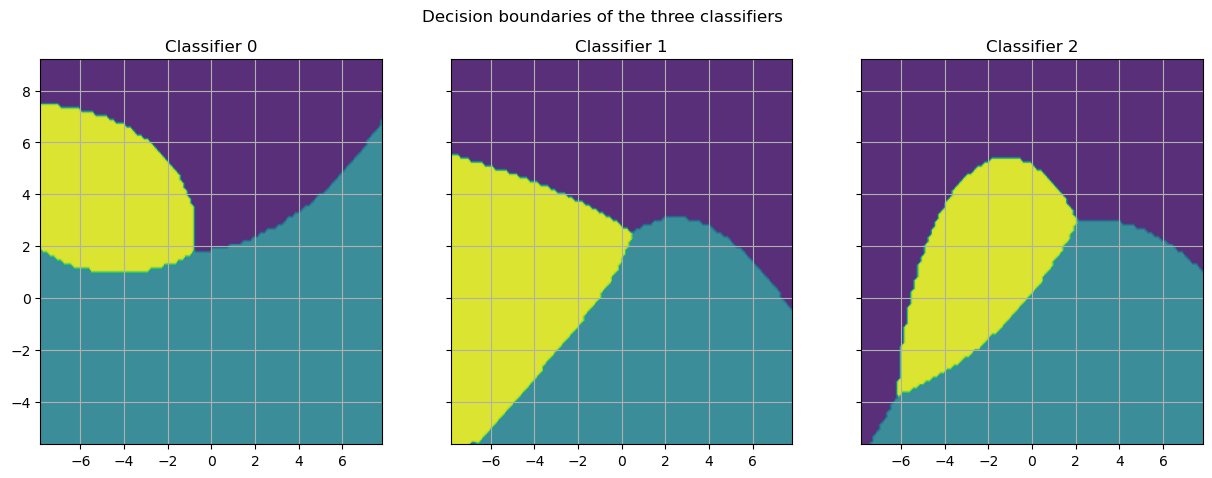

In [295]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
for i, ax in enumerate(axes.flatten()):
    plot_decision_boundary(classifiers[i], ax, X, f'Classifier {i}')
plt.suptitle('Decision boundaries of the three classifiers')
plt.show()

<div align="justify">

We can get a more compact visualization of their differences by plotting the number of different predictions for a point in the area instead:

</div>

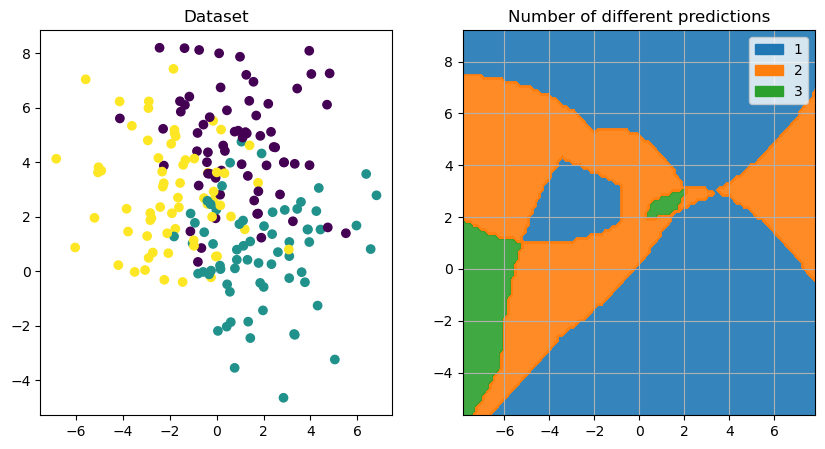

In [296]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
plot_differnces_in_boundary(classifiers, X, ax2)
ax1.scatter(X[:,0], X[:,1], c=y)
ax1.set_title('Dataset')
plt.show()

<div align="justify">

We will use this representation later to compare the results of the different uncertainty measures to.

</div>

### Hartley Measure

<div align="justify">

The standard uncertainty measure in classical possibility theory (where uncertain information is simply represented in the form of subsets $A \subseteq \mathcal{Y}$ of possible alternatives) is the Hartley measure [^beaware] ({cite:t}`hart_to28`)

$$
\begin{equation}\label{eq:hartley}
H(A) = \log( |A|)  \, ,
\end{equation}
$$(hartley)


</div>

[^beaware]:Be aware that we denote both the Hartley measure and the Shannon entropy by $H$, which is common in the literature. The meaning should be clear from the context.


In [297]:
def hartley_measure(A):
    return np.log2(len(A))

set_sizes = range(1, 11)
hartley_values = [hartley_measure(set(range(1, size + 1))) for size in set_sizes]

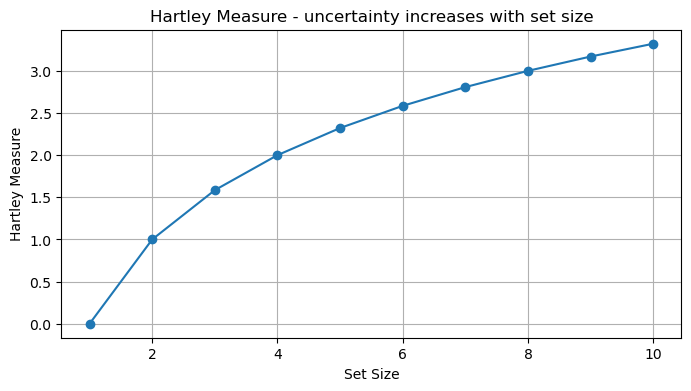

In [298]:
# visualize
plt.figure(figsize=(8, 4))
plt.plot(set_sizes, hartley_values, marker='o')
plt.title('Hartley Measure - uncertainty increases with set size')
plt.xlabel('Set Size')
plt.ylabel('Hartley Measure')
plt.grid(True)
plt.show()

<div align="justify">

Just like the Shannon entropy (cf. {doc}`../chapter-modelingAproxUncertainty/modelingAproxUncertainty`), this measure can be justified axiomatically[^hartleymeasureaxiom]. 

Given the insight that conflict and non-specificity are two different, complementary sources of uncertainty, and standard (Shannon) entropy and ({eq}`hartley`) as well-established measures of these two types of uncertainty, a natural question in the context of credal sets is to ask for a generalized representation

$$
\begin{equation}
\text{U}(Q) = \text{AU}(Q) + \text{EU}(Q) \, ,
\end{equation}
$$(aggregate)

where $\text{U}$ is a measure of total (aggregate) uncertainty, $\text{AU}$ a measure of aleatoric uncertainty (conflict, a generalization of the Shannon entropy), and $\text{EU}$ a measure of epistemic uncertainty (non-specificity, a generalization of the Hartely measure). 

</div>

[^hartleymeasureaxiom]: For example, see Chapter IX, pages 540--616, in the book by {cite:t}`reny_pt`.


### Generalized Hartley Measure

<div align="justify">


As for the non-specificity part in ({eq}`aggregate`), the following generalization of the Hartley measure to the case of graded possibilities has been proposed by various authors {cite:t}`abel_an00`:

$$
\begin{equation}
GH(Q) := \sum_{A \subseteq \mathcal{Y}} \text{m}_Q(A) \, \log(|A|) \,,
\end{equation}
$$(gh)

where $\mathrm{m}_Q: \,  2^{\mathcal{Y}} \longrightarrow [0,1]$ is the Möbius inverse of the capacity function $\nu :\, 2^{\mathcal{Y}} \longrightarrow [0,1]$ defined by

$$
\begin{equation}
\nu_Q(A) := \inf_{q \in Q} q(A) 
\end{equation}
$$(cap)

for all $A \subseteq \mathcal{Y}$, that is,

$$
\text{m}_Q(A) = \sum_{B \subseteq A} (-1)^{|A \setminus B|} \nu_Q(B) \, .
$$

</div>

The measure ({eq}`gh`) enjoys several desirable axiomatic properties, and its uniqueness was shown by {cite:t}`klir_ot87`.


In [299]:
def get_powerset(A):
    # helper function to get powerset of a set
    s = list(A)
    powerset = {frozenset(comb) for comb in chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))}
    return powerset

def vq(A, credal_sets):
    # helper to compute the measure vq
    idx = list(A)
    vq = np.min(np.sum(credal_sets[:,:,idx], axis=2), axis=1)

    return vq
    
def mq(A, credal_sets):
    # computes the mq measure as moebius inverse of vq
    
    powerset = get_powerset(A)
    
    mq = np.sum(np.array([(((-1)**len(A-B))*vq(B, credal_sets)) for B in powerset]),axis=0)
    
    return mq
    
def get_gh_measure(credal_sets):
    # computes generalized Hartley measure
    
    # add axis if single set
    if len(credal_sets.shape) == 2:
        credal_sets = credal_sets[np.newaxis, :, :]
        
    # compute powerset over classes
    n_classes = credal_sets.shape[-1]
    powerset = get_powerset({idx for idx in range(n_classes)})
    
    # compute GH measure
    GH = np.sum(np.array([mq(A, credal_sets)*hartley_measure(A) 
                 for A in powerset if len(A)]),axis=0)
    
    return GH

<div align="justify">


Now we compute a first uncertainty measure on our posterior credal sets by computing the generalized hartley measure on them. We can get a feeling for it by inspecting the credal sets for which the measure is the lowest and the highest:

</div>

In [300]:
gh = get_gh_measure(credal_sets)
credal_sets[np.argmax(gh)]

array([[0.043, 0.619, 0.338],
       [0.044, 0.   , 0.956],
       [0.811, 0.   , 0.189]])

In [301]:
credal_sets[np.argmin(gh)]

array([[0.   , 1.   , 0.   ],
       [0.003, 0.996, 0.001],
       [0.   , 1.   , 0.   ]])

<div align="justify">


Now we can visualize the generalized hartley measure by creating a heatmap in the color at a point corresponds to the uncertainty of the credal set for the prediction at that point.
Comparing the result with the visualizations we created before shows the measure tends to be high for the credal sets for which we also have more different predictions:

</div>

In [302]:
def plot_uncertainty_heatmap(X, y, measure, classifiers, title, cmap):
	x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
	y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    
	x_grid = np.linspace(x_min,x_max, 100)
	y_grid = np.linspace(y_min, y_max, 100)
    
	xv, yv = np.meshgrid(x_grid,y_grid)
    
	points = np.column_stack((xv.ravel(), yv.ravel()))
    
	mesh_probabilities = []

	for classifier in classifiers:
		p = classifier.predict_proba(points)
		mesh_probabilities.append(p)

	mesh_credal_sets = np.transpose(np.array(mesh_probabilities), (1,0,2))
	measure_res = measure(mesh_credal_sets).reshape((100,100))
    
	fig = plt.figure(figsize=(16,6))
	gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.1)
    
	ax1 = fig.add_subplot(gs[0, 0])
	ax2 = fig.add_subplot(gs[0, 1])
	ax3 = fig.add_subplot(gs[0, 2])
	cax = fig.add_subplot(gs[0, 3])

	titles = ['Dataset', 'n different predictions', 'uncertainty measure heatmap']
    
	for i, ax in enumerate([ax1, ax2, ax3]):
		ax.set_xlim(x_min, x_max)
		ax.set_ylim(y_min, y_max)
		ax.grid(True)
		ax.set_title(titles[i])
    
	ax2.set_yticklabels([])
	ax3.set_yticklabels([])

	ax1.scatter(X[:,0], X[:,1], c=y, edgecolor='k')
	
	plot_differnces_in_boundary(classifiers, X, ax2)

	contour = ax3.contourf(x_grid, y_grid, measure_res, cmap=cmap)

	cbar = plt.colorbar(contour, cax=cax)

	plt.suptitle(title)
	plt.show()

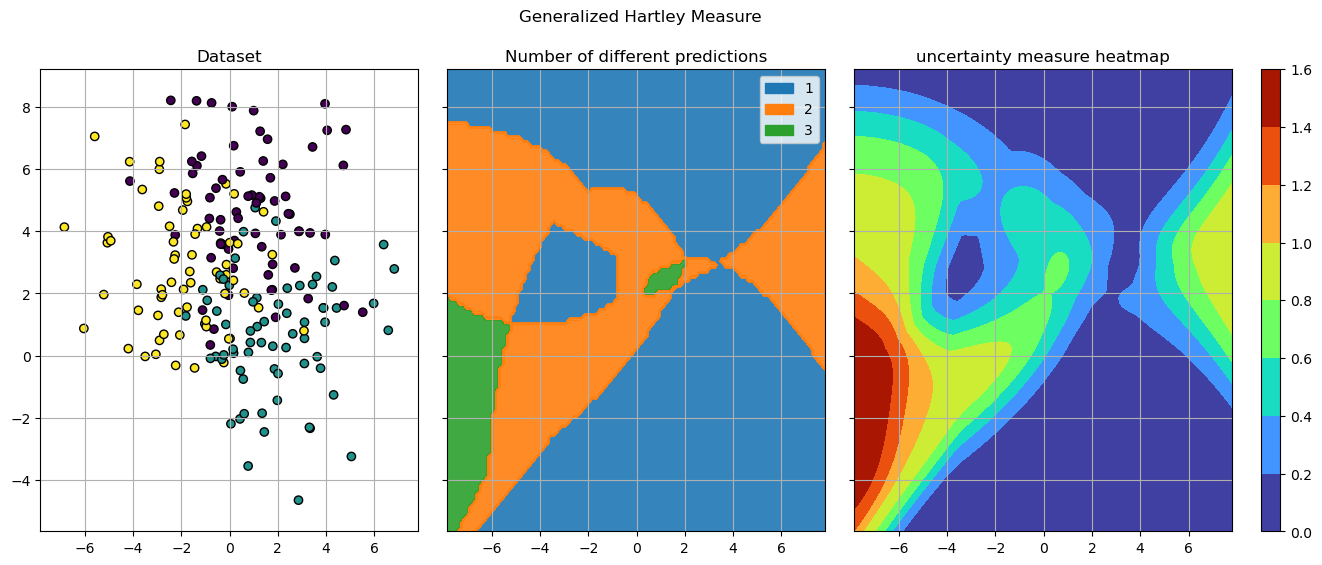

In [303]:
title = 'Generalized Hartley Measure'
plot_uncertainty_heatmap(X, y, get_gh_measure, classifiers, title, 'turbo')

<div align="justify">


For a different illustration we also compute the uncertainty measures on the posterior credal set of the wine data that we obtained earlier and visualize the credal sets with the highest and lowest uncertainty:

</div>

In [304]:
def plot_uncertainty_triangle(credal_sets, measure_res, name):
	fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5), subplot_kw={'projection': 'ternary'})

	ridx = [np.argmin(measure_res), np.argmax(measure_res)]
	val = [np.min(measure_res).round(3), np.max(measure_res).round(3)]
    
	for i, ax in enumerate(axes):

		credal_set = credal_sets[ridx[i]]
		point = point_predictions[ridx[i]]
        
		ax.scatter(credal_set[:,0], credal_set[:,1], credal_set[:,2], marker='.', s=10, alpha=0.5, color='blue')
        #ax.scatter(*credal_set[:,:], marker='.', s=10, alpha=0.5, color='blue')
		ax.scatter(*point, color='red')
		ax.set_title(f'{val[i]}')
	fig.text(0.5, 0.01, f"""Credal sets for minimal and maximal {name} measure.""", 
                           ha='center', fontsize=12)
	plt.show()

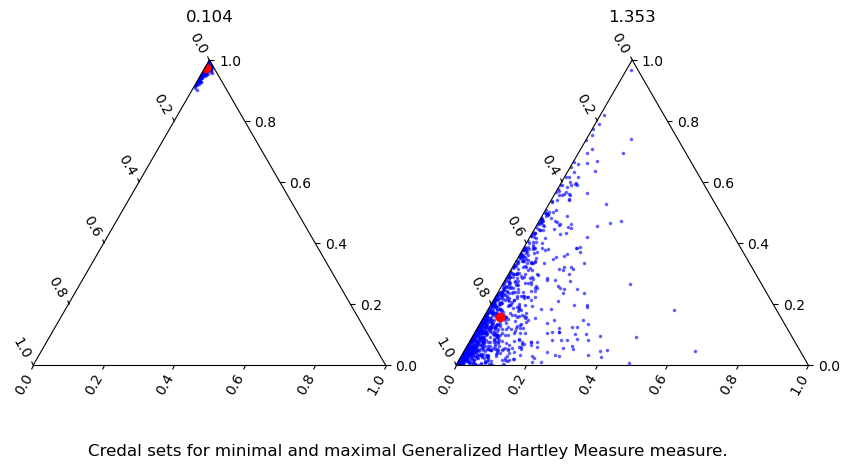

In [305]:
wine_hartley_measure = get_gh_measure(wine_credal_sets)

name = 'Generalized Hartley Measure'
plot_uncertainty_triangle(wine_credal_sets, wine_hartley_measure, name)

### Upper and Lower Shannon entropy


<div align="justify">

The generalization of the Shannon entropy $H$ as a measure of conflict turned out to be more difficult. The upper and lower Shannon entropy play an important role in this regard: 

$$
H^*(Q) := \max_{q \in Q} H(q) \, , \quad
H_*(Q) := \min_{q \in Q} H(q)
$$

</div>

In [306]:
def get_shannon_entropy(credal_sets):
    
    # add axis if single set
    if len(credal_sets.shape) == 2:
        credal_sets = credal_sets[np.newaxis, :, :]
    
    shannon = -np.sum(credal_sets * np.log2(credal_sets+1e-50), axis=2)
    
    return shannon

def get_upper_shannon(credal_sets):
    
    # add axis if single set
    if len(credal_sets.shape) == 2:
        credal_sets = credal_sets[np.newaxis, :, :]
    
    shannon = get_shannon_entropy(credal_sets)
    
    upper_shannon = np.max(shannon, axis=1)
    
    upper_shannon = np.round(upper_shannon, 4)
    
    return upper_shannon

def get_lower_shannon(credal_sets):
    
    # add axis if single set
    if len(credal_sets.shape) == 2:
        credal_sets = credal_sets[np.newaxis, :, :]
    
    shannon = get_shannon_entropy(credal_sets)
    
    lower_shannon = np.min(shannon, axis=1)
    
    lower_shannon = np.round(lower_shannon, 4)
    
    return lower_shannon


<div align="justify">

With this we can compute the upper and lower shannon entropy on our credal sets. Again we look at the credal sets that show the lowest and highest uncertainty and visualize the measure:

</div>

In [307]:
upper_shannon = get_upper_shannon(credal_sets)
print(f'Credal set with maximal Upper Shannon entropy:\n{credal_sets[np.argmax(upper_shannon)]}\n')
print(f'Credal set with minimal Upper Shannon entropy:\n{credal_sets[np.argmin(upper_shannon)]}')

Credal set with maximal Upper Shannon entropy:
[[0.41  0.317 0.273]
 [0.265 0.281 0.454]
 [0.056 0.076 0.869]]

Credal set with minimal Upper Shannon entropy:
[[0.    1.    0.   ]
 [0.003 0.996 0.001]
 [0.    1.    0.   ]]


<div align="justify">


We visualize the Upper Shannon entropy in the same way as before. We can see that it is still highest in the areas, where the classifiers disagree the most. However, it seems to capture more uncertainty also in other areas.


</div>

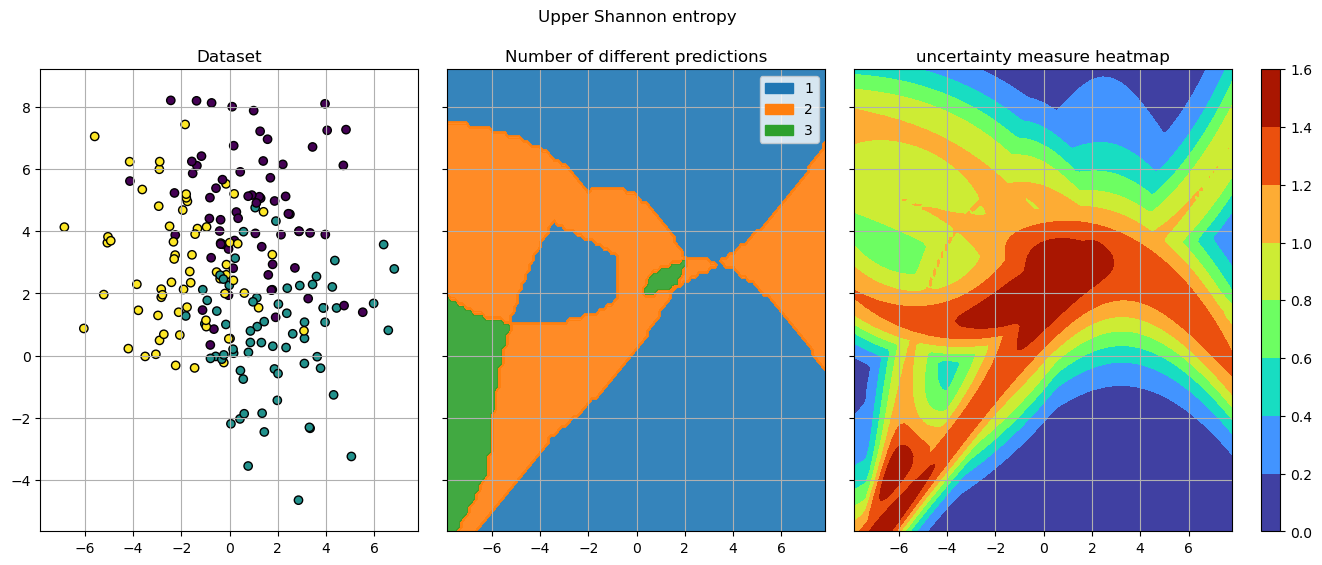

In [308]:
title = 'Upper Shannon entropy '
plot_uncertainty_heatmap(X, y, get_upper_shannon, classifiers, title, 'turbo')

Again we also look at the wine credal sets with the highest and lowest uncertainty:

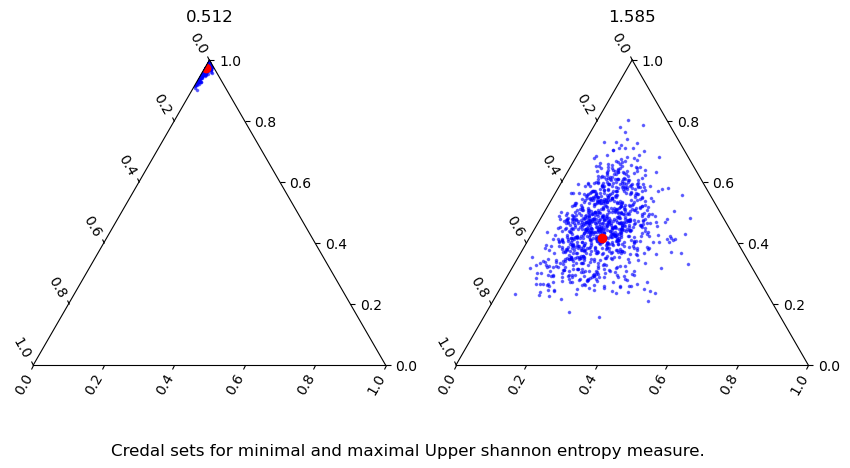

In [309]:
wine_upper_shannon = get_upper_shannon(wine_credal_sets)

name = 'Upper shannon entropy'
plot_uncertainty_triangle(wine_credal_sets, wine_upper_shannon, name)

We do the same for the Lower Shannon Entropy:

In [310]:
lower_shannon = get_lower_shannon(credal_sets)
print(f'Credal set with maximal Lower Shannon entropy:\n{credal_sets[np.argmax(lower_shannon)]}\n')
print(f'Credal set with minimal Lower Shannon entropy:\n{credal_sets[np.argmin(lower_shannon)]}')

Credal set with maximal Lower Shannon entropy:
[[0.652 0.263 0.085]
 [0.397 0.429 0.174]
 [0.293 0.278 0.429]]

Credal set with minimal Lower Shannon entropy:
[[0.    1.    0.   ]
 [0.003 0.996 0.001]
 [0.    1.    0.   ]]


<div align="justify">


Again we use the same visualization. We can see that the Lower Shannon entropy captures much less uncertainty than the other two. It is even zero in some areas where the classifiers disagree.

</div>

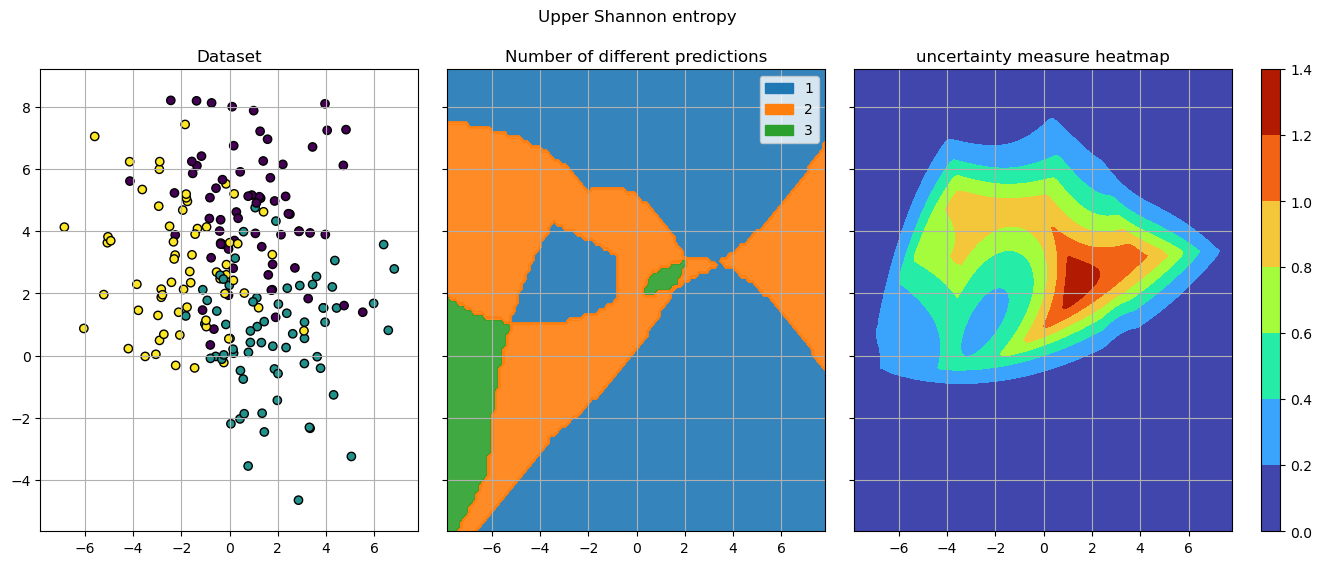

In [311]:
title = 'Upper Shannon entropy '
plot_uncertainty_heatmap(X, y, get_lower_shannon, classifiers, title, 'turbo')

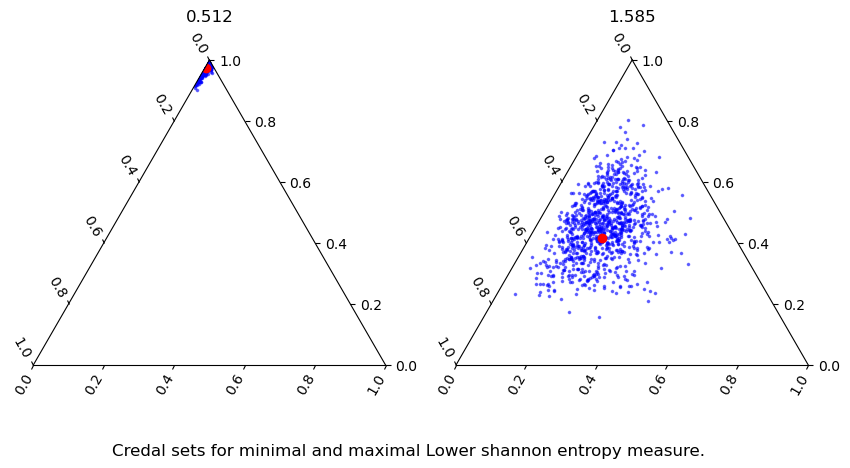

In [312]:
wine_lower_shannon = get_upper_shannon(wine_credal_sets)

name = 'Lower shannon entropy'
plot_uncertainty_triangle(wine_credal_sets, wine_upper_shannon, name)

## Uncertainty Decomposition

<div align="justify">


Based on these measures, the following disaggregations of total uncertainty {eq}`aggregate` have been proposed {cite:t}`abel_dt06`:
a
\begin{align}
H^*(Q) = \big(H^*(Q) - \text{GH}(Q) \big)  + \text{GH}(Q)
\end{align}(unc1)
\begin{align}
H^*(Q) = H_*(Q)  + \big(H^*(Q) - H_*(Q) \big)
\end{align}(unc2)

In both cases, upper entropy serves as a measure of total uncertainty $U(Q)$, which is again justified on an axiomatic basis. In the first case, the generalized Hartley measure is used for quantifying epistemic uncertainty, and aleatoric uncertainty is obtained as the difference between total and epistemic uncertainty. In the second case, epistemic uncertainty is specified in terms of the difference between upper and lower entropy.  


</div>

We can realize both uncertainty decompositions by combining our previous results:

In [313]:
def decomposition_1(credal_sets):
    
    gh = get_gh_measure(credal_sets)
    us = get_upper_shannon(credal_sets)
    
    aleatoric = us - gh
    epistemic = gh
    
    return aleatoric, epistemic

In [314]:
def decomposition_2(credal_sets):
    
    ls = get_lower_shannon(credal_sets)
    us = get_upper_shannon(credal_sets)
    
    aleatoric = ls
    epistemic = us - ls
    
    return aleatoric, epistemic

In [315]:
aleatoric1, epistemic1 = decomposition_1(credal_sets)

aleatoric2, epistemic2 = decomposition_2(credal_sets)

<div align="justify">


We can look at the credal sets of the queries with maximal epistemic and maximal aleatoric uncertainty. In case of the high epistemic uncertainty, we can see that the entropy of the individual distributions is not very high and it wouldnt be a problem to make a prediction based on only one of them, however the uncertainty comes from their strong disagreement:

</div>

In [316]:
# epistemic uncertainty estimate decomposition 1
print(f'Max epistemic uncertainty. Decomposition 1:\n{credal_sets[np.argmax(epistemic1)]}\n')

# epistemic uncertainty estimate decomposition 2
print(f'Max epistemic uncertainty. Decomposition 2:\n{credal_sets[np.argmax(aleatoric2)]}\n')

Max epistemic uncertainty. Decomposition 1:
[[0.043 0.619 0.338]
 [0.044 0.    0.956]
 [0.811 0.    0.189]]

Max epistemic uncertainty. Decomposition 2:
[[0.652 0.263 0.085]
 [0.397 0.429 0.174]
 [0.293 0.278 0.429]]



<div align="justify">


When looking at the credal sets with the highest aleatoric uncertainty we can see that the entropy within the single distributions is very high which means it also might be difficult to make a prediction in that area if we could reduce the epistemic uncertainty:

</div>

In [317]:
# aleatoric uncertainty estimate decomposition 1
print(f'Max aleatoric uncertainty. Decomposition 1:\n{credal_sets[np.argmax(aleatoric1)]}\n')
#aleatoric uncertainty estimate decomposition 2
print(f'Max aleatoric uncertainty. Decomposition 2:\n{credal_sets[np.argmax(aleatoric2)]}')

Max aleatoric uncertainty. Decomposition 1:
[[0.325 0.66  0.014]
 [0.284 0.594 0.122]
 [0.185 0.732 0.082]]

Max aleatoric uncertainty. Decomposition 2:
[[0.652 0.263 0.085]
 [0.397 0.429 0.174]
 [0.293 0.278 0.429]]


In [318]:
aleatoric1_w, epistemic1_w = decomposition_2(wine_credal_sets)

We can again visualize the credal sets with minimal and maximal uncertainty:

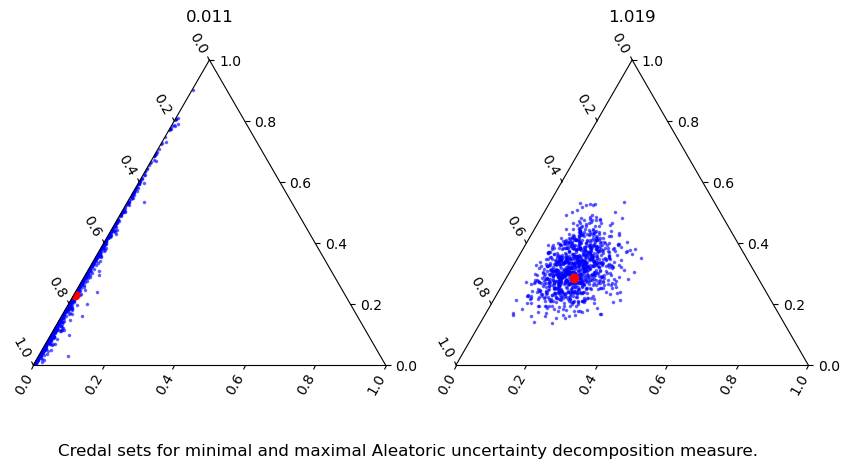

In [319]:
plot_uncertainty_triangle(wine_credal_sets, aleatoric1_w, 'Aleatoric uncertainty decomposition')

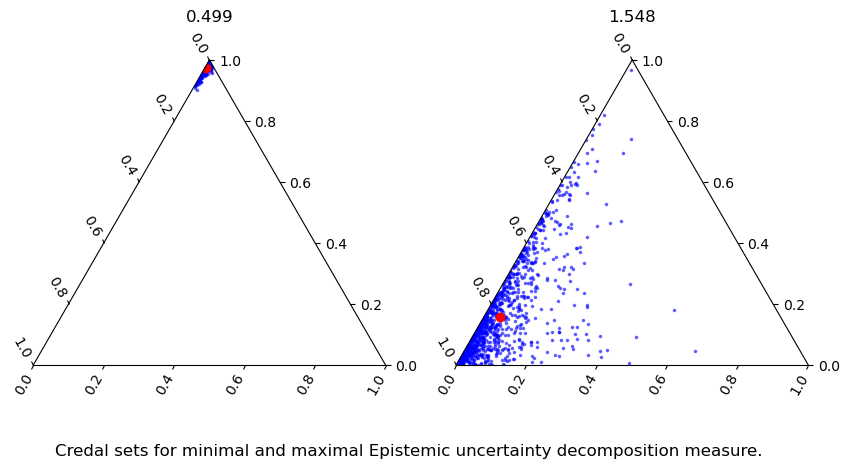

In [320]:

plot_uncertainty_triangle(wine_credal_sets, epistemic1_w, 'Epistemic uncertainty decomposition')

(set_predictions)=
## Set-valued prediction

<div align="justify">

Credal classifiers are used for "indeterminate" prediction, that is, to produce reliable set-valued predictions that are likely to cover the true outcome. In this regard, the notion of *dominance* plays an important role: An outcome $y$ dominates another outcome $y'$ if $y$ is more probable than $y'$ for each distribution in the credal set, that is,

\begin{align}
\gamma(y,y', \vec{x}) :=
\inf_{h \in C} \frac{p( y | \vec{x}_q, h)}{p(y' | \vec{x}_q, h)}  > 1 \, ,
\end{align}(dominance)
where $C$ is a credal set of hypotheses, and $p( y | \vec{x}, h)$ the probability of the outcome $y$ (for the query $\vec{x}_q$) under hypothesis $h$. 

</div>

First we define a function to capture the notion of dominance within a credal set:

In [321]:
def is_dominated(y, yprime, credal_sets):
    
    dominated = np.all(credal_sets[:,:,y] > 
                       credal_sets[:,:,yprime][:,:,np.newaxis],axis=1)
    
    return dominated

In the following credal set class 1 is dominated by class 0, as class probabilities are higher across all distributions in the set. However it is not dominated by class 2 since the class probability for 2 in the first distribution isnt higher:

In [322]:
c = np.array([[0.719, 0.279, 0.003],
			  [0.823, 0.027, 0.15],
			  [0.643, 0.122, 0.235]])

is_dominated(y=[0,2], yprime=1, credal_sets = c[np.newaxis, :])

array([[ True, False]])

<div align="justify">


The set-valued prediction for a query $\vec{x}_q$ is then given by the set of all non-dominated outcomes $y \in \set{Y}$, i.e., those outcomes that are not dominated by any other outcome.
Practically, the computations are based on the interval-valued probabilities 
$[\underline{p}(y | \vec{x}_q), \overline{p}(y || \vec{x}_q)]$
assigned to each class $y \in \set{Y}$, where 
\begin{align}
\underline{p}(y | \vec{x}_q) := \inf_{h \in C} p(y | \vec{x}_q, h)\, , \quad \overline{p}(y | \vec{x}_q) := \sup_{h \in C} p(y | \vec{x}_q, h) \, .
\end{align}(inter_pro)
Note that the upper probabilities $\overline{p}(y | \vec{x}_q)$ are very much in the spirit of the plausibility degrees (\ref{eq:plaus}) (equation in chapter 4.7 not there yet).

</div>

We define another function to determine which classes are not dominated across all our credal sets. With this we can then do set valued prediction:

In [323]:
def get_not_dominated(credal_sets):
    
    n_samples, _, n_classes = credal_sets.shape
    
    # Create a matrix to hold the dominance results
    dominance = np.zeros((n_samples, n_classes), dtype=bool)
    
    for yprime in range(n_classes):
        y = np.arange(n_classes) != yprime
        
        # for each sample check if class is dominated by any other
        is_dominated_by = np.any(is_dominated(y, yprime, credal_sets), axis=1)
        
        # class is not dominated if is_dominated is false
        dominance[:, yprime] = ~is_dominated_by
    
    return dominance

def get_set_predictions(credal_sets):
    
    _, _, n_classes = credal_sets.shape
    
    not_dominated = get_not_dominated(credal_sets)
    
    predictions = [np.arange(n_classes)[idx] for idx in not_dominated]
    
    return predictions

In [324]:
set_predictions = get_set_predictions(credal_sets)
set_predictions[0:10]

[array([0]),
 array([0, 2]),
 array([1]),
 array([0, 2]),
 array([2]),
 array([0]),
 array([0]),
 array([1, 2]),
 array([0, 1, 2]),
 array([0])]

In [325]:
def plot_cardinality_old(classifiers, X, target):

	x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
	y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    
	x = np.linspace(x_min,x_max, 100)
	y = np.linspace(y_min, y_max, 100)

	xv, yv = np.meshgrid(x,y)
    
	points = np.column_stack((xv.ravel(), yv.ravel()))

	mesh_probabilities = []

	for classifier in classifiers:
		p = classifier.predict_proba(points)
		mesh_probabilities.append(p)

	mesh_credal_sets = np.transpose(np.array(mesh_probabilities), (1,0,2))
    
	set_predictions = get_set_predictions(mesh_credal_sets)
	cardinalities = np.array([len(x) for x in set_predictions])
	cardinalities = cardinalities.reshape((100,100))

	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
	titles = ['Dataset', 'N different predictions', 'Cardinality prediction set']

	for i, ax in enumerate(axes):
		ax.set_xlim(x_min, x_max)
		ax.set_ylim(y_min, y_max)
		ax.grid(True)
		ax.set_title(titles[i])
	
	(ax1, ax2, ax3) = axes
	ax2.set_yticklabels([])
	ax3.set_yticklabels([])
	print(cardinalities.shape)
	ax1.scatter(X[:,0], X[:,1], c=target, edgecolor='k')

	plot_differnces_in_boundary(classifiers, X, ax2)
	
	# Define a custom colormap
	colors = ['red', 'blue', 'green']
	cmap = mcolors.ListedColormap(colors)
	bounds = [0, 1, 2, 3]
	norm = mcolors.BoundaryNorm(bounds, cmap.N)

	# Create a legend
	legend_labels = {
        0: "1",
        1: "2",
        2: "3"
    }
    
	patches = [Patch(color=colors[i], label=label) for i, label in legend_labels.items()]
	
	contour = ax3.contourf(x, y, cardinalities, cmap=cmap, alpha=0.9)
	ax3.legend(handles=patches, loc='upper right')
	ax3.set_title('Cardinality of prediction set')
	ax3.grid(True)
	
	plt.show()
 
def plot_cardinality(classifiers, X, target):
	number_of_classes = 3 # parameter used for the colors

	x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
	y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    
	x = np.linspace(x_min,x_max, 100)
	y = np.linspace(y_min, y_max, 100)

	xv, yv = np.meshgrid(x,y)
    
	points = np.column_stack((xv.ravel(), yv.ravel()))

	mesh_probabilities = []

	for classifier in classifiers:
		p = classifier.predict_proba(points)
		mesh_probabilities.append(p)

	mesh_credal_sets = np.transpose(np.array(mesh_probabilities), (1,0,2))
    
	set_predictions = get_set_predictions(mesh_credal_sets)
	cardinalities = np.array([len(x) for x in set_predictions])
	cardinalities = cardinalities.reshape((100,100))

	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
	titles = ['Dataset', 'N different predictions', 'Cardinality prediction set']

	for i, ax in enumerate(axes):
		ax.set_xlim(x_min, x_max)
		ax.set_ylim(y_min, y_max)
		ax.grid(True)
		ax.set_title(titles[i])
	
	(ax1, ax2, ax3) = axes
	ax2.set_yticklabels([])
	ax3.set_yticklabels([])
	print(cardinalities.shape)
	ax1.scatter(X[:,0], X[:,1], c=target, edgecolor='k')

	plot_differnces_in_boundary(classifiers, X, ax2)
	 
    # Build the Discrete Color Map
	cmap = mpl.colormaps["tab10"] # define the colormap. As 3 colors are already used for the plot_differnces_in_boundary we use the next 3 colors

 
    # extract all colors from cmap
	cmaplist = [cmap(i) for i in range(3,6)] # take the next 3 unused colors from the cmap. The first 3 are used n plot_differnces_in_boundary
 
    # create the new map
	cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, len(cmaplist)) 
    
    # define the bins and normalize
	bounds = np.linspace(0, number_of_classes+1, number_of_classes+1)
	norm = mpl.colors.BoundaryNorm(bounds, number_of_classes)

	# Create a legend
	legend_labels = {
        0: "1",
        1: "2",
        2: "3"
    }
    
	patches = [Patch(color=cmap(norm(i+1)), label=label) for i, label in legend_labels.items()]
	
	contour = ax3.contourf(x, y, cardinalities, cmap=cmap, alpha=0.9)
 
 
 
	ax3.legend(handles=patches, loc='upper right')
	ax3.set_title('Cardinality of prediction set')
	ax3.grid(True)
	
	plt.show()



<div align="justify">


We now visualize the cardinality of the prediction set next to the dataset and the number of predictions:

</div>

(100, 100)


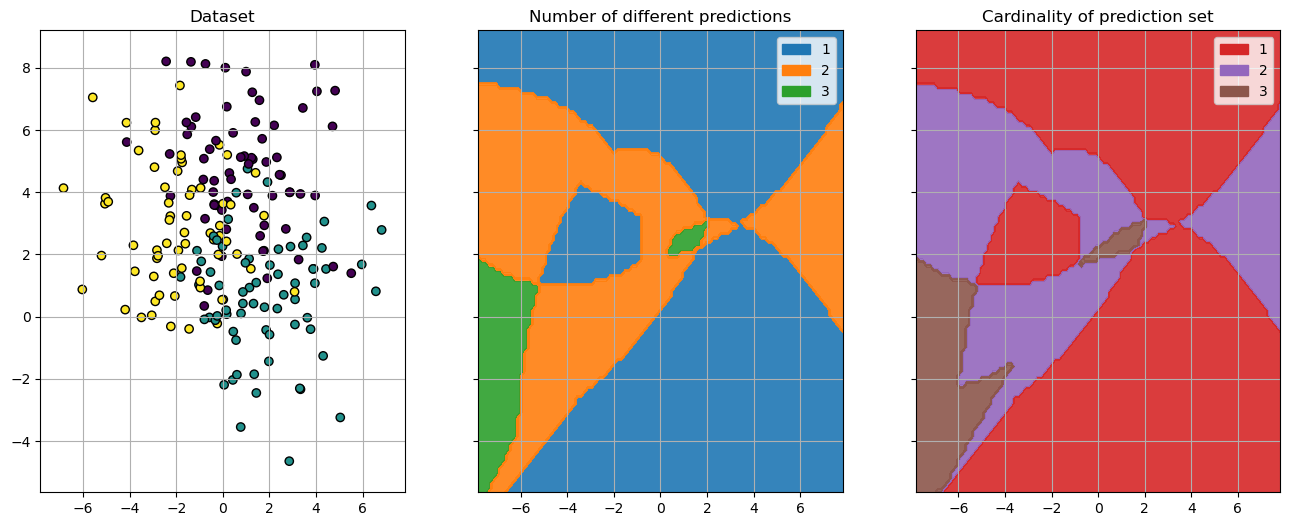

In [326]:
plot_cardinality(classifiers, X, y)

<div align="justify">


Now we can also create a set prediction for the wine credal set we obtained at the beginning. We visualize three credal sets for which we received different sized set predictions, in the same way as before:

</div>

In [327]:
wine_set_predictions = get_set_predictions(wine_credal_sets)
wine_set_predictions[:10]

[array([0, 2]),
 array([0, 2]),
 array([2]),
 array([0]),
 array([1]),
 array([0]),
 array([1, 2]),
 array([2]),
 array([1]),
 array([2])]

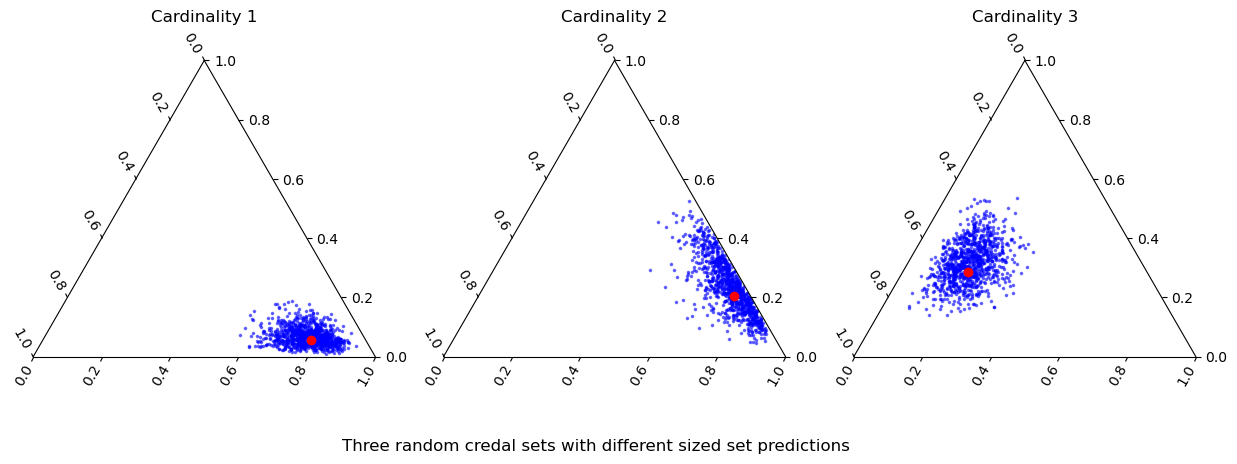

In [328]:
ridx = [np.random.choice(np.argwhere(np.array([len(x) for x in wine_set_predictions])==i)[:,0]) for i in range(1,4)]
title = "Three random credal sets with different sized set predictions"
axtitles = ['Cardinality 1', 'Cardinality 2', 'Cardinality 3']
create_posterior_plot(wine_credal_sets, point_predictions, ridx, title, axtitles)

### Dominance degrees

<div align="justify">


Interestingly, uncertainty degrees can be derived on the basis of dominance degrees (\ref{eq:dominance}). For example, the following uncertainty score has been proposed by {cite:t}`antonucci2012` in the context of uncertainty sampling for active learning:


\begin{align}
s(\vec{x}_q) := - \max \big(\gamma(+1, -1, \vec{x}_q ), \gamma(-1, +1, \vec{x}_q ) \big) \, .
\end{align}(scoreNcc)

For data sets with more than two classes the score generalizes as follows:

\begin{align}
s(\vec{x}_q) := - \sum_{c' \in \mathcal{C}} \sum_{c'' \in \mathcal{C} \setminus \{c'\}} \max[\gamma(c', c''), \gamma(c'', c')]
\end{align}


</div>


In [329]:
def get_dominance_degrees(credal_sets):
    # Computes dominance degrees on credal sets 
    _, _, n_classes = credal_sets.shape
    
    # Create a matrix to hold the dominance results
    scores = []
    
    for yprime in range(n_classes):
        y = np.arange(n_classes) != yprime
        
        a = np.min(credal_sets[:, :,yprime][:,:,np.newaxis] / (credal_sets[:, :, y] +1e-8), axis=1)
        b = np.min(credal_sets[:, :,y] / (credal_sets[:, :, yprime][:,:,np.newaxis] +1e-8), axis=1)
        

        s = np.sum(np.max(np.array([a, b]), axis=0), axis=1)
        
        scores.append(s)
        
    scores = -np.sum(np.array(scores),axis=0)

    scores = np.round(scores,4)
    
    return scores

With this we compute the dominance degrees on our wine credal sets:

In [330]:
dominance_degrees = get_dominance_degrees(wine_credal_sets)

In [331]:
np.mean(dominance_degrees)

-21.019783333333336

In [332]:
dominance_degrees

array([ -8.5397,  -6.287 ,  -5.0387,  -8.8752,  -8.0609,  -8.8752,
       -17.4435, -10.9688,  -6.8588, -10.9688,  -1.9801,  -6.7124,
       -10.9688,  -0.9523,  -8.8752, -10.9688, -18.1132, -19.3644,
       -91.9595, -18.1132, -91.9595, -18.083 , -24.9303,  -7.8137,
        -3.6982,  -6.287 ,  -3.6982,  -3.6982, -18.1132,  -3.6982,
       -91.9595,  -1.4145, -10.9688,  -6.5464, -91.9595, -91.9595])

<div align="justify">


This degree is low if one of the outcomes strongly dominates the other one, but high if this is not the case. It is closely related to the degree of epistemic uncertainty in (\ref{eq:ep}) to be discussed in Section \ref{sec:uqnl}, but also seems to capture some aleatoric uncertainty. In fact, $s(\vec{x}_q)$ increases with both, the width of the interval $[\underline{p}(y | \vec{x}_q) , \overline{p}(y | \vec{x}_q)]$ as well as the closeness of its middle point to $\frac{1}{2}$.


</div>

We can illustrate this by visualising credal sets with different dominance degrees in the barycentric coordinate system:

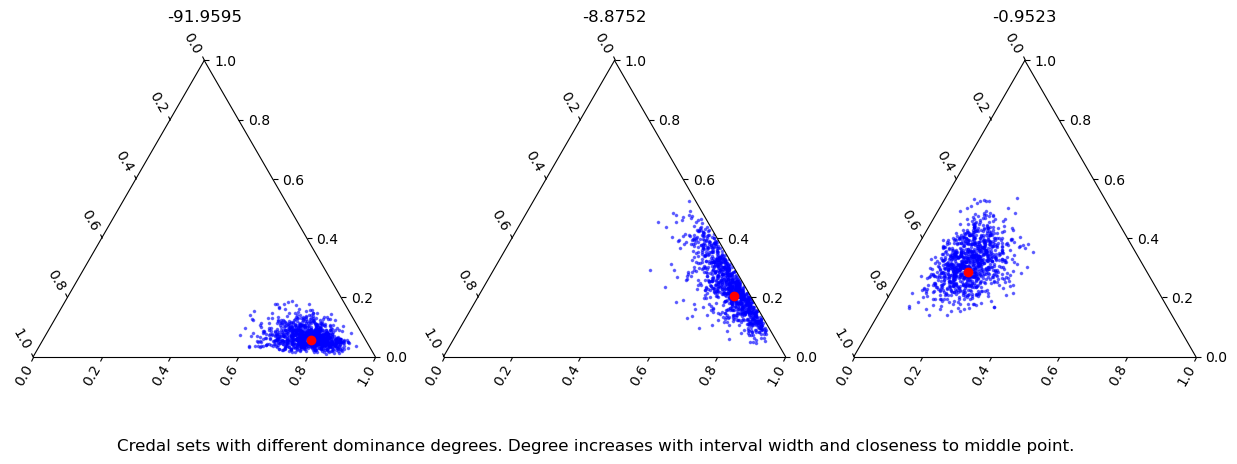

In [333]:
min_idx, max_idx = np.argmin(dominance_degrees), np.argmax(dominance_degrees)
med_idx = np.where(np.median(dominance_degrees) == dominance_degrees)[0][0]
idx = [min_idx, med_idx, max_idx]
title = "Credal sets with different dominance degrees. Degree increases with interval width and closeness to middle point."
axtitles = [dominance_degrees[min_idx], dominance_degrees[med_idx], dominance_degrees[max_idx]]
create_posterior_plot(wine_credal_sets, point_predictions, ridx, title, axtitles)

<div align="justify">


{cite:t}`lass_rc20` discusses the modeling of *credal imprecision* by means of sets of measures in a critical way and contrasts this approach with hierarchical probabilistic (Bayesian) models, i.e., distributions of measures. Among several arguments put forward against sets-of-measures models, one aspect is specifically interesting from a machine learning perspective, namely the problem that modeling a lack of knowledge in a set-based manner may hamper the possibility of inductive inference, up to a point where learning from empirical data is not possible any more. This is closely connected to the insight that learning from data necessarily requires an inductive bias, and learning without assumptions is not possible {cite:t}`wolp_tl96`. To illustrate the point, consider the case of complete ignorance as an example, which could be modeled by the credal set $\mathbb{P}_{all}$ that contains all probability measures (on a hypothesis space) as candidate priors. Updating this set by pointwise conditioning on observed data will essentially reproduce the same set as a credal set of posteriors. Roughly speaking, this is because $\mathbb{P}_{all}$ will contain very extreme priors, which will remain extreme even after updating with a sample of finite size. In other words, no finite sample is enough to annihilate a sufficiently extreme prior belief. Replacing $\mathbb{P}_{all}$ by a proper subset of measures may avoid this problem, but any such choice (implying a sharp transition between possible and excluded priors) will appear somewhat arbitrary. According to {cite:t}`lass_rc20`, an appealing alternative is using a probability distribution instead of a set, like in hierarchical Bayesian modeling.


</div>